In [26]:
# Useful to have
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Need for messing with the Fashion MNIST dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

# Fitting Models to MNIST Fashion Data Set
This exercise will show you how to use TF to build a deep NN model that classifies elements of the Fashion MNIST data set.

In [27]:
fashion_mnist_ds = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist_ds.load_data()
# From tutorial code - here are the names of the labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [28]:
print(X_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


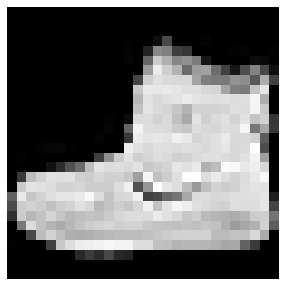

In [29]:
plt.figure(figsize=(5,5))
plt.imshow(X_train[0,:,:], cmap='gray')
plt.axis('off')
plt.show()

In [30]:
print("{0}...or, '{1}' ".format(y_train[0], class_names[y_train[0]]))

9...or, 'Ankle boot' 


**Note**: NNs need to have data scaled between $[0,1]$ or $[-1,1]$.

In [31]:
X_train = X_train / 255.0
X_test = X_test / 255.0

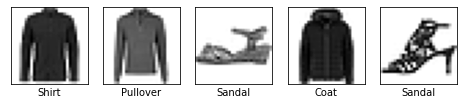

In [32]:
# Look at a few of them...
plt.figure(figsize=(8,10))
num = 5
idxs = np.random.choice(X_train.shape[0], num)
i = 1
for idx in idxs:
    plt.subplot(1,num,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[idx], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[idx]])
    i += 1
plt.show()

In [49]:
# And finally, let's convert the labels into one-hot encoding!
y_train_onehot = keras.utils.to_categorical(y_train, num_classes=len(class_names))
y_test_onehot = keras.utils.to_categorical(y_test, num_classes=len(class_names))
rand_idx = np.random.randint(y_train.shape[0])
# Example:
print("Original integer: {0}\nAs one-hot vector: {1}".format(y_train[rand_idx], y_train_onehot[rand_idx]))

Original integer: 7
As one-hot vector: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Let's build up a model with the Tensorflow's `keras.Sequential` python API.
There are several [layer types](https://www.tensorflow.org/api_docs/python/tf/keras/layers) we can use.
To start, let's build a standard multi-layer perceptron, since we know theoretically all we need is a single hidden layer to approximate any continuous function.

**Note: MLPs do not operate on 2d data!**
We need to add a pass through later called `Flatten` to convert the 28x28 images into a 784 dimensional vector.

In [34]:
img_shape = X_train[0].shape
num_elements = img_shape[0]*img_shape[1]
print("An image is a vector with {0} x {1} = {2} elements".format(img_shape[0], img_shape[1], num_elements))
fashion_classifier_model = keras.Sequential()
# "Dense" is the same as "Fully Connected"
fashion_classifier_model.add(Flatten(input_shape=img_shape))
fashion_classifier_model.add(Dense(int(num_elements / 2), activation='relu'))
fashion_classifier_model.add(Dense(10, activation='softmax')) # These are 10 logits.

An image is a vector with 28 x 28 = 784 elements


Let's see what our model really outputs with some image...

In [35]:
print(fashion_classifier_model.predict(X_train[0:1]))
print(y_train_onehot[0:1])

[[0.0867728  0.11654683 0.09867404 0.05747173 0.04192814 0.04425249
  0.23758768 0.15343665 0.12926066 0.03406895]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


The model is built, now you need to pick a [loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses). 
The categories are represented with integers, so we will need to use Categorical Cross Entropy.

In [36]:
loss_func = keras.losses.CategoricalCrossentropy()

In [37]:
# Build the end-to-end optimization structure
fashion_classifier_model.compile(optimizer='adam',
                                loss=loss_func,
                                metrics=['accuracy'])

In [38]:
# We invoke the fitting process: Graident Descent!
fashion_classifier_model.fit(X_train, y_train_onehot, epochs=1, batch_size=32)

1875/1875 [==============================] - 2s 1ms/step - loss: 0.4760 - accuracy: 0.8303

In [39]:
# Now you need to evaluate on the test set to see how you did!
fashion_classifier_model.evaluate(X_test, y_test_onehot, verbose=2)

313/313 - 0s - loss: 0.4133 - accuracy: 0.8498


[0.4132538437843323, 0.8497999906539917]

Not bad! But let's look at the model structure. How many weights do we have?

In [40]:
fashion_classifier_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                3930      
Total params: 311,650
Trainable params: 311,650
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Let's fire up a prediction
test_img = X_test[0:1]
print("Array of scores - we can consider each value a confidence.")
pred = fashion_classifier_model.predict(test_img)
print(pred)

Array of scores - we can consider each value a confidence.
[[1.2265800e-05 4.9096150e-07 1.7460262e-06 1.4811719e-06 2.7079163e-06
  3.9267384e-02 3.6451029e-06 4.6863120e-02 1.9396603e-04 9.1365319e-01]]


In [42]:
# To extract the most likely class, we take the argmax!
pred_idx = np.argmax(fashion_classifier_model.predict(test_img))
print("We predicted input image as {0} with confidence {1}".format(class_names[pred_idx], pred[0][pred_idx]))
print(y_test_onehot[0])

We predicted input image as Ankle boot with confidence 0.9136531949043274
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Convolutional NN Model
In this example, we swap out MLP for CNNs. They are generally more efficient on 2D data. 

In [43]:
# Have to reshape the data, since convolutional layers are expecting images with channels.
X_train_cnn = X_train.reshape(60000, 28, 28, 1)

In [44]:
fashion_classifier_cnnmodel = keras.Sequential()
# Convolutional networks couple Convolution layers with pooling to boost efficiency.
fashion_classifier_cnnmodel.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)))
fashion_classifier_cnnmodel.add(MaxPool2D(pool_size=2))
fashion_classifier_cnnmodel.add(Flatten())
fashion_classifier_cnnmodel.add(Dense(10, activation='softmax'))

In [45]:
fashion_classifier_cnnmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                125450    
Total params: 125,770
Trainable params: 125,770
Non-trainable params: 0
_________________________________________________________________


In [46]:
# SAME training process...just a different model.
fashion_classifier_cnnmodel.compile(optimizer='adam',
                                    loss=loss_func,
                                    metrics=['accuracy'])

In [47]:
fashion_classifier_cnnmodel.fit(X_train_cnn, y_train_onehot, epochs=1, batch_size=32)

1875/1875 [==============================] - 16s 8ms/step - loss: 0.4151 - accuracy: 0.8555

In [48]:
X_test_cnn = X_test.reshape(10000, 28, 28, 1)
fashion_classifier_model.evaluate(X_test_cnn, y_test_onehot, verbose=2)

313/313 - 0s - loss: 0.4133 - accuracy: 0.8498


[0.4132538437843323, 0.8497999906539917]